In [16]:
import subprocess
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm 

# --- CONFIG ---
DOCKER_SERVER = "pqc-server"
DOCKER_CLIENT = "pqc-client"
OPENSSL_BIN = "openssl" 
PORT = "4433"

ALGORITHMS = [
    "prime256v1",
    "mlkem512",
    "mlkem768",
    "mlkem1024",
    "X25519MLKEM768"
]

SCENARIOS = [
    {"name": "1. Ideal",            "delay": 0,   "loss": 80},

]

ITERATIONS = 10

In [17]:
def set_network_conditions(container, delay_ms, loss_percent):
    # Reset
    subprocess.run(["docker", "exec", "--privileged", container, "tc", "qdisc", "del", "dev", "eth0", "root"], stderr=subprocess.DEVNULL)
    if delay_ms == 0 and loss_percent == 0: return

    # Set
    cmd = ["docker", "exec", "--privileged", container, "tc", "qdisc", "add", "dev", "eth0", "root", "netem"]
    if delay_ms > 0: cmd.extend(["delay", f"{delay_ms}ms"])
    if loss_percent > 0: cmd.extend(["loss", f"{loss_percent}%"])
    subprocess.run(cmd, stderr=subprocess.DEVNULL)

def stop_server():
    subprocess.run(["docker", "exec", DOCKER_SERVER, "pkill", "openssl"], stderr=subprocess.DEVNULL)

def run_handshake_debug(algo):
    stop_server()
    
    # 1. Server starten
    cmd_server = [
        "docker", "exec", "-d", DOCKER_SERVER, 
        "sh", "-c", 
        f"{OPENSSL_BIN} s_server -cert /certs/cert.pem -key /certs/key.pem -accept {PORT} -tls1_3 -groups {algo} -www"
    ]
    subprocess.run(cmd_server)
    time.sleep(1) 
    
    # 2. Client starten
    start = time.perf_counter()
    cmd_client = [
        "docker", "exec", DOCKER_CLIENT,
        "sh", "-c",
        f"echo 'Q' | {OPENSSL_BIN} s_client -connect {DOCKER_SERVER}:{PORT} -groups {algo} -tls1_3 -CAfile /certs/cert.pem"
    ]
    
    try:
        res = subprocess.run(cmd_client, capture_output=True, text=True, timeout=10)
        end = time.perf_counter()
        
        if res.returncode == 0 or "Verification: OK" in res.stdout or "Cipher :" in res.stdout:
            return (end - start) * 1000
        else:
            if "verify error" in res.stderr:
                 print(f"Zertifikats-Fehler bei {algo} - Ignoriere ihn...")
                 return (end - start) * 1000
            
            print(f"DEBUG FAIL {algo}: {res.stderr[:100]}...") 
            return None
            
    except subprocess.TimeoutExpired:
        return None

In [18]:
results = []
print("Starte Benchmark (Server-Side Loss)...")

try:
    for scen in SCENARIOS:
        print(f"\n--- Szenario: {scen['name']} ---")
        
        set_network_conditions(DOCKER_SERVER, scen['delay'], scen['loss'])
    
        
        for algo in tqdm(ALGORITHMS):
            for i in range(ITERATIONS):
                lat = run_handshake_debug(algo)
                
                if lat:
                    results.append({"Scenario": scen['name'], "Algorithm": algo, "Latency_ms": lat, "Status": "Success"})
                else:
                    results.append({"Scenario": scen['name'], "Algorithm": algo, "Latency_ms": 15000, "Status": "Failed"})
                    
finally:
    set_network_conditions(DOCKER_SERVER, 0, 0)
    set_network_conditions(DOCKER_CLIENT, 0, 0)
    stop_server()

Starte Benchmark (Server-Side Loss)...

--- Szenario: 1. Ideal ---


100%|██████████| 5/5 [05:14<00:00, 62.92s/it]


In [19]:
# Auswertung
df = pd.DataFrame(results)
fail_rate = df.groupby(['Scenario', 'Algorithm'])['Status'].apply(lambda x: (x == 'Failed').mean() * 100).unstack()
print("\nFehlerraten (%):")
display(fail_rate)


Fehlerraten (%):


Algorithm,X25519MLKEM768,mlkem1024,mlkem512,mlkem768,prime256v1
Scenario,,,,,
1. Ideal,40.0,30.0,40.0,30.0,20.0


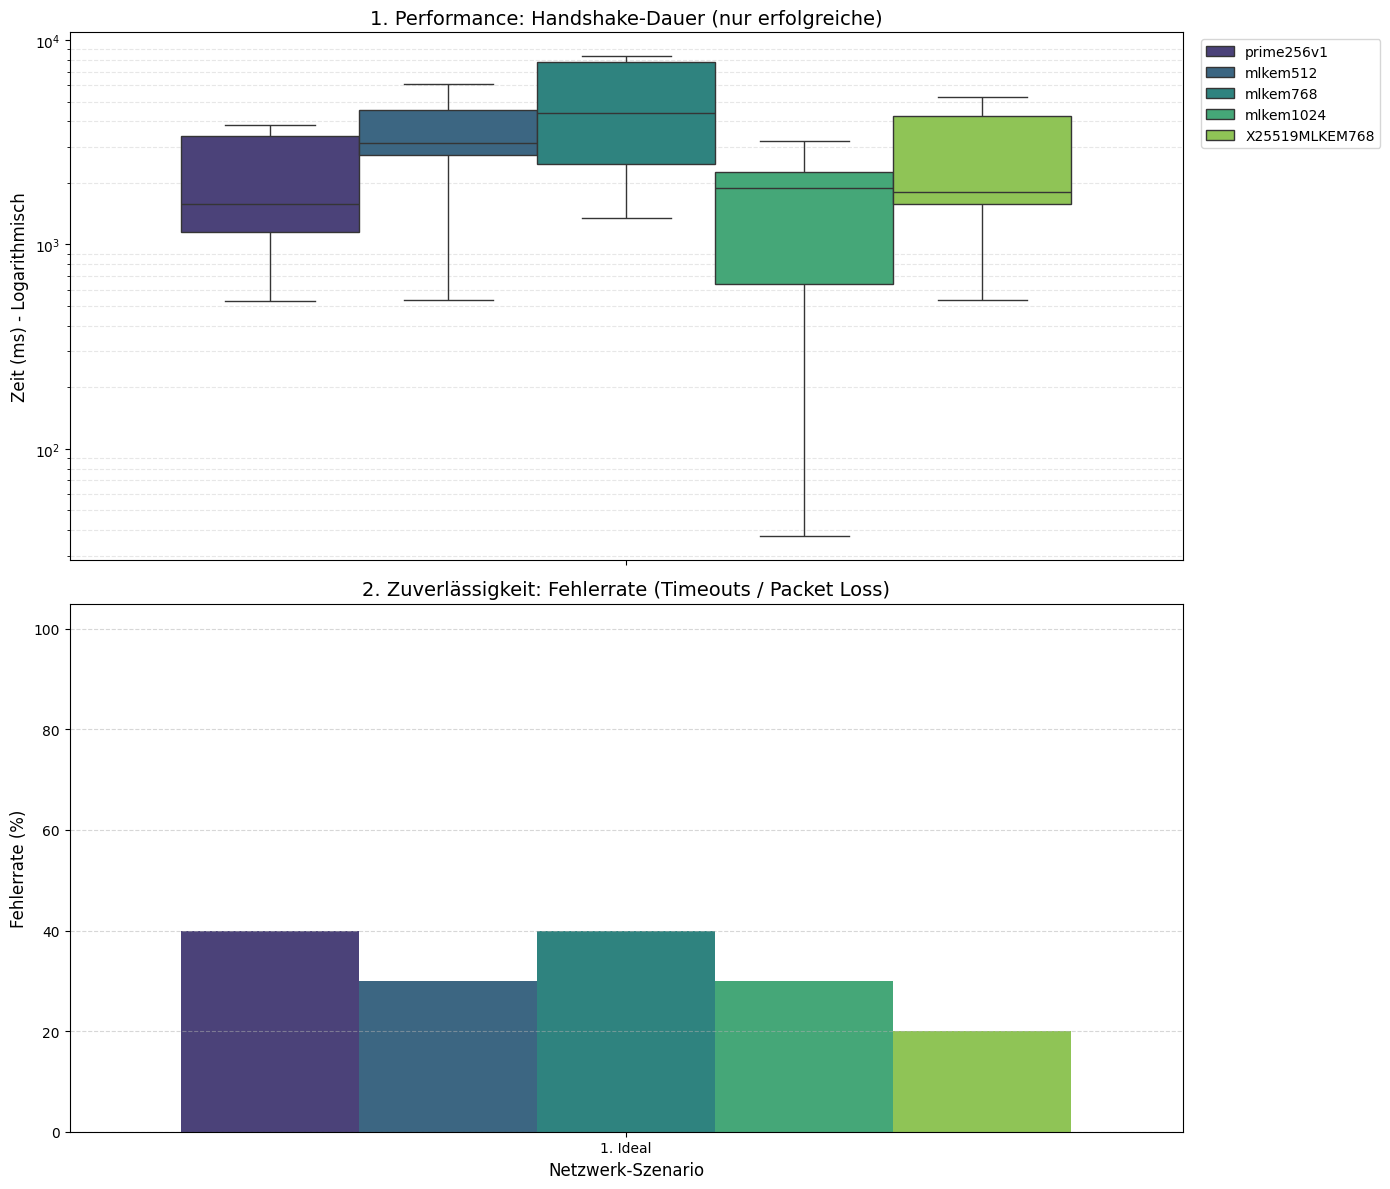

Durchschnittliche Latenz (ms):


Algorithm,X25519MLKEM768,mlkem1024,mlkem512,mlkem768,prime256v1
Scenario,,,,,
1. Ideal,2666.1,1559.9,3415.6,4952.9,2494.4



Fehlerraten (%):


Algorithm,X25519MLKEM768,mlkem1024,mlkem512,mlkem768,prime256v1
Scenario,,,,,
1. Ideal,40.0,30.0,40.0,30.0,20.0


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_success = df[df['Status'] == 'Success'].copy()

df_fail = df.groupby(['Scenario', 'Algorithm'])['Status'].apply(lambda x: (x == 'Failed').mean() * 100).reset_index()
df_fail.rename(columns={'Status': 'Failure Rate (%)'}, inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

sns.boxplot(
    data=df_success,
    x="Scenario",
    y="Latency_ms",
    hue="Algorithm",
    palette="viridis",
    showfliers=False,
    ax=ax1
)
ax1.set_title("1. Performance: Handshake-Dauer (nur erfolgreiche)", fontsize=14)
ax1.set_ylabel("Zeit (ms) - Logarithmisch", fontsize=12)
ax1.set_yscale("log")
ax1.grid(True, which="minor", ls="--", alpha=0.3)
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

sns.barplot(
    data=df_fail,
    x="Scenario",
    y="Failure Rate (%)",
    hue="Algorithm",
    palette="viridis",
    ax=ax2
)
ax2.set_title("2. Zuverlässigkeit: Fehlerrate (Timeouts / Packet Loss)", fontsize=14)
ax2.set_ylabel("Fehlerrate (%)", fontsize=12)
ax2.set_xlabel("Netzwerk-Szenario", fontsize=12)
ax2.set_ylim(0, 105)
ax2.grid(True, axis='y', ls="--", alpha=0.5)
ax2.get_legend().remove() 

plt.tight_layout()
plt.show()

print("Durchschnittliche Latenz (ms):")
display(df_success.groupby(['Scenario', 'Algorithm'])['Latency_ms'].mean().unstack().round(1))
print("\nFehlerraten (%):")
display(df.groupby(['Scenario', 'Algorithm'])['Status'].apply(lambda x: (x == 'Failed').mean() * 100).unstack())